In [ ]:
# hide
# all_tutorial

# Small Molecule Affinity Optimization

>Small molecule affinity optimization

## Affinity Optimization

This tutorial runs an end to end workflow for designing high affinity ligands using generative screening. We will design potential ligands against [EGFR](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor), a protein implicated in several types of cancer.

Here is an outline of the workflow we will follow:
1. Design score function
2. Design chemical space
3. Load pre-trained model
4. Fine-tune pre-trained model
5. Reinforcement learning
6. Analysis

In [ ]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *

from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.vocab import *
from mrl.policy_gradient import *
from mrl.train.all import *
from mrl.model_zoo import *
from sklearn.metrics import r2_score

/home/dmai/miniconda3/envs/mrl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [ ]:
os.makedirs('untracked_files', exist_ok=True)

## The Target

EGFR is a transmembrane protein receptor for growth factors. When growth factors bind to EGFR on the cell surface, it initiates a cascade of signals inside the cell. This triggers the cell to initiate gene transcription and cell proliferation.

Overexpression of EGFR can lead to accelerated cell division which can result in tumors. This mechanism has been implicated in several types of cancer, including adenocarcinoma of the lung and glioblastoma.

## Data

We will specifically target the `ErbB1` form of EFGR, which has the ChEMBL ID `CHEMBL203`. Our dataset comes from ChEMBL. It contains affinity measurements from 6509 small molecule drugs.

In [ ]:
df = pd.read_csv('../files/erbB1_affinity_data.csv')

In [ ]:
df.head()

,smiles,neg_log_ic50,chembl_id,set
0,Brc1cc2c(NCc3ccccc3)ncnc2s1,6.617983,CHEMBL3416599,valid
1,Brc1cc2c(NCc3ccccn3)ncnc2s1,5.102153,CHEMBL3416616,train
2,Brc1cc2c(NCc3cccs3)ncnc2s1,5.862013,CHEMBL3416619,train
3,Brc1cc2c(NCc3ccncc3)ncnc2s1,5.410833,CHEMBL3416614,train
4,Brc1cc2c(Nc3ccccc3)ncnc2s1,7.096910,CHEMBL3416621,train


In [ ]:
df.shape

(6467, 4)

In [ ]:
df['smiles_ns'] = df.smiles.map(lambda x: remove_stereo(x))

The affinity value is given as `-log_10(IC50)` These values range from 0 to 12, where higher values correspond with higher affinity

<AxesSubplot:>

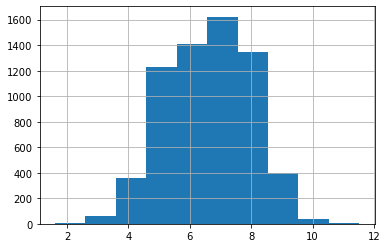

In [ ]:
df.neg_log_ic50.hist()

## Approved Drugs

There are seven approved drugs in the dataset. All drugs are FDA approved except for `Icotinib`, which is only approved in China.

In [ ]:
drug_smiles = [
    'COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1',
    'C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1',
    'CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC1CCOC1',
    'COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(Nc2ccccc2P(C)(C)=O)n1',
    'C#Cc1cccc(Nc2ncnc3cc4c(cc23)OCCOCCOCCO4)c1',
    'CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2)o1',
    'C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(OC)cc1N(C)CCN(C)C'
]

drug_names = [
    'Gefitinib',
    'Erlotinib',
    'Afatinib',
    'Brigatinib',
    'Icotinib',
    'Lapatinib',
    'Osimertinib'
]

drug_dict = {drug_smiles[i]:drug_names[i] for i in range(len(drug_names))}

In [ ]:
subset = df[df.smiles_ns.isin(drug_smiles)].copy()
subset.reset_index(inplace=True, drop=True)
subset['name'] = subset.smiles_ns.map(lambda x: drug_dict[x])
subset.drop_duplicates(subset='name', inplace=True)

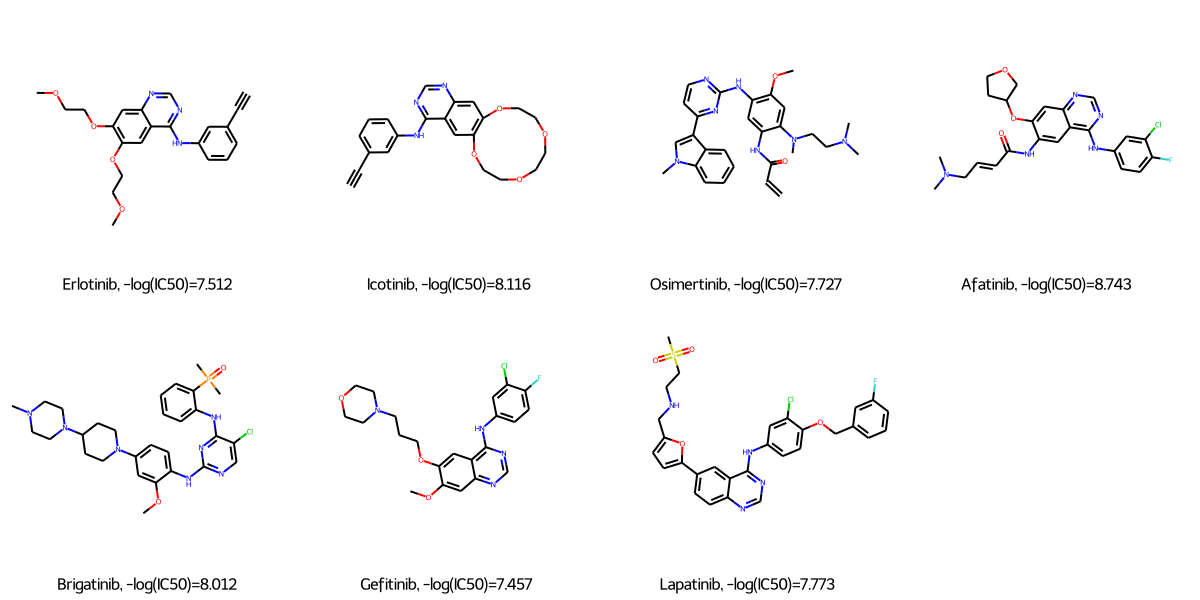

In [ ]:
mols = to_mols(subset.smiles_ns.values)
names = subset.name.values
acts = subset.neg_log_ic50.values
legends = [f"{names[i]}, -log(IC50)={acts[i]:.3f}" for i in range(len(names))]
draw_mols(mols, legends=legends, mols_per_row=4)

It is worth noting that the approved drugs are not the highest affinity binders in the dataset. The top 8 highest affinity binders are shown below. This illustrates how affinity alone is not sufficient for making a drug

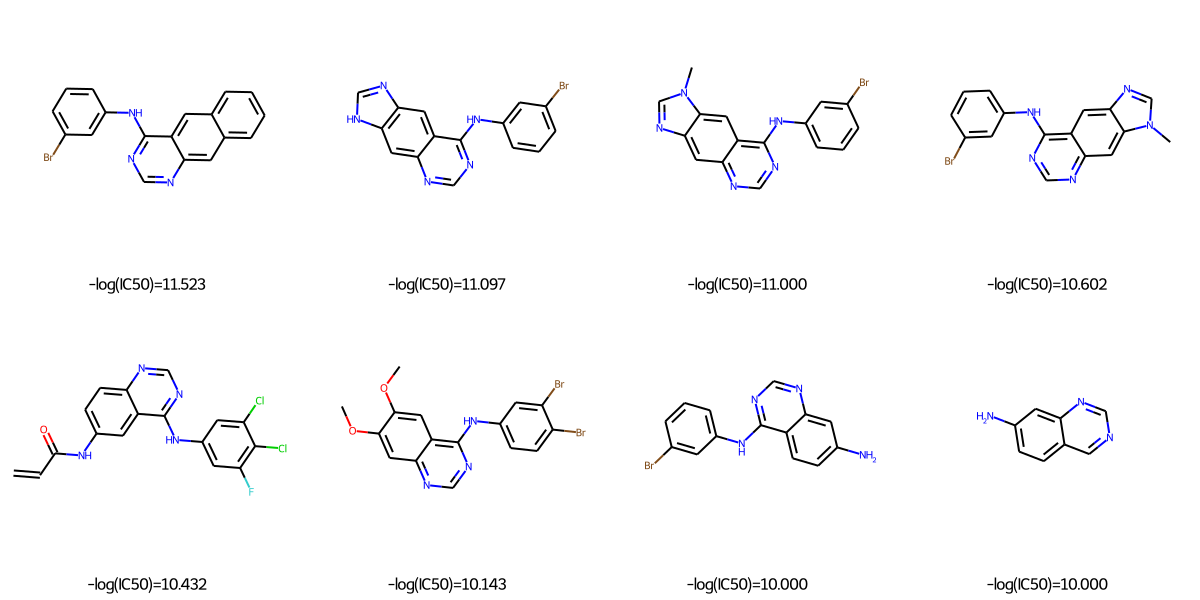

In [ ]:
subset2 = df.iloc[df.neg_log_ic50.nlargest(8).index]

mols = to_mols(subset2.smiles_ns.values)
acts = subset2.neg_log_ic50.values
legends = [f"-log(IC50)={acts[i]:.3f}" for i in range(len(mols))]
draw_mols(mols, legends=legends, mols_per_row=4)

## Score Function

Now we want to develop a score function for predicting binding affinity. We are going to use a MLP-type model to predict affinity from an `ECFP6` fingerprint.

We will train on 90% of the data and validate on the 10% held out.

In [ ]:
df_train = df[df.set=='train']
df_valid = df[df.set=='valid']

In [ ]:
reward_model = MLP(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2], outrange=[0,15])
r_ds = Vec_Prediction_Dataset(df_train.smiles_ns.values, df_train.neg_log_ic50.values, ECFP6)
r_agent = PredictiveAgent(reward_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

In [ ]:
r_agent.train_supervised(32, 10, 1e-3, percent_valid=0.1)

Epoch,Train Loss,Valid Loss,Time
0,1.54977,0.28657,00:06
1,1.05367,0.65758,00:06
2,1.08841,0.31990,00:06
3,0.43909,0.24786,00:06
4,0.46526,0.33699,00:06
5,0.30168,0.30161,00:06
6,0.20798,0.51298,00:06
7,0.18604,0.34009,00:06
8,0.11575,0.30871,00:06
9,0.19196,0.32855,00:06


Optional: save score function weights

In [ ]:
# r_agent.save_weights('untracked_files/egfr_affinity_mlp.pt')

Optional: to load the exact weights used, run the following:

In [ ]:
# r_agent.load_state_dict(model_from_url('egfr_affinity_mlp.pt'))

In [ ]:
# validate

valid_ds = Vec_Prediction_Dataset(df_valid.smiles_ns.values, df_valid.neg_log_ic50.values, ECFP6)

valid_dl = valid_ds.dataloader(256, num_workers=0, shuffle=False)
r_agent.model.eval();

preds = []
targs = []

with torch.no_grad():
    for i, batch in enumerate(valid_dl):
        batch = to_device(batch)
        x,y = batch
        pred = r_agent.model(x)
        preds.append(pred.detach().cpu())
        targs.append(y.detach().cpu())
        
preds = torch.cat(preds).numpy()
targs = torch.cat(targs).numpy()

preds = preds.squeeze(-1)

Our score function has an r^2 value of about 0.72 on the validation dataset

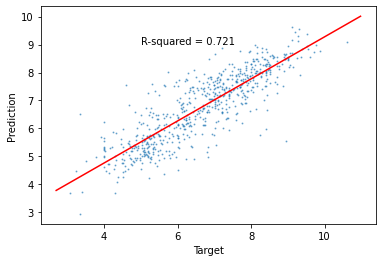

In [ ]:
fig, ax = plt.subplots()

ax.scatter(targs, preds, alpha=0.5, s=1)
plt.xlabel('Target')
plt.ylabel('Prediction')

slope, intercept = np.polyfit(targs, preds, 1)
ax.plot(np.array(ax.get_xlim()), intercept + slope*np.array(ax.get_xlim()), c='r')

plt.text(5., 9., 'R-squared = %0.3f' % r2_score(targs, preds));

We should also take a look at the prediction distribution for our known actives. The predicted values will differ somewhat from the actual values. This will give us a sense of what score we want to see from the model 

In [ ]:
df['preds'] = r_agent.predict_data(df.smiles.values).detach().cpu().numpy()

In [ ]:
df.preds.max()

9.820236

In [ ]:
np.percentile(df.preds, 99)

9.123940906524659

The maximum predicted value is `9.8`. A compound scoring `9.12` or higher would be in the top 1% of all known actives

## Chemical Space

Next we need to develop our chemical space. This is where we decide what compounds will be allowed and what compounds will be removed.

Getting the right filtering parameters makes a huge difference in compound quality. In practice, finding the right constraints is an interative process. First run a generative screen. Then examine the highest scoring compounds and look for undesirable properties or structural features. Then update the template and iterate.

In [ ]:
smarts = ['[#6](=[#16])(-[#7])-[#7]',
        '[#6]=[#6]=[#6]',
        '[#7][F,Cl,Br,I]',
        '[#6;!R]=[#6;!R]-[#6;!R]=[#6;!R]']

template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 8),
                     HeteroatomFilter(None, 8),
                     ChargeFilter(None, 0),
                     MaxRingFilter(None, 6),
                     MinRingFilter(5, None),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     MolWtFilter(None, 500),
                     LogPFilter(None, 5),
                     SAFilter(None, 7),
                     BridgeheadFilter(None,0),
                     PAINSAFilter(),
                     ExclusionFilter(smarts, criteria='any'),
                     RotChainFilter(None, 7)
                    ],
                    [], 
                    fail_score=-1., log=False, use_lookup=True)

template_cb = TemplateCallback(template, prefilter=True)

## Load Model

We load the `LSTM_LM_Small_ZINC_NC` model. This is a basic LSTM-based language model trained on part of the ZINC database

In [ ]:
agent = LSTM_LM_Small_ZINC_NC(drop_scale=0.3, opt_kwargs={'lr':5e-5})

## Fine-Tune Model

The pretrained model we loaded is a very general model that can produce a high diversity of structures. One problem with this is roughly 60-70% of all generated compounds from the pretrained model won't match our template. This makes training slower and less efficient, because the model is wasting time generating compounds that get filtered out.

We also want to make use of our affinity dataset to bias the model towards known high affinity structures.

To make the model better conform to the template and the known actives dataset, we will run a two step fine-tuning process.

First we will generate a small dataset of compounds from the model, and filter that dataset using the template. We will then fine-tune on the template-passing dataset. This could also be done on a pre-existing dataset. Generating a dataset here is only done to make the notebook more self-contained.

In [ ]:
set_global_pool(10)

Here we generate aa set of SMILES. If you have some time on your hands, feel free to generate more. The generative model is capable of producing millions of unique SMILES with a low rate of invalid or duplicate SMILES

In [ ]:
%%time
all_smiles = set()
for i in range(200):
    preds, _ = agent.model.sample_no_grad(2500, 120)
    smiles = agent.reconstruct(preds)
    mols = to_mols(smiles)
    smiles = [smiles[i] for i in range(len(smiles)) if mols[i] is not None]
    all_smiles.update(set(smiles))

CPU times: user 22min 33s, sys: 39.3 s, total: 23min 12s
Wall time: 2min 52s


In [ ]:
set_global_pool(64)

Here we filter the SMILES with the template

In [ ]:
all_smiles = list(all_smiles)
hps = np.array(template(all_smiles))
df2 = pd.DataFrame(all_smiles, columns=['smiles'])
df2 = df2[hps]

Optional: save dataset

In [ ]:
df2.to_csv('untracked_files/pretrain_data.csv', index=False)

In [ ]:
close_global_pool()

Now we fine-tune on our new template-conforming dataset

In [ ]:
# df2 = pd.read_csv('untracked_files/pretrain_data.csv')
agent.update_dataset_from_inputs(df2.smiles.values)
agent.train_supervised(128, 4, 1e-5)
agent.base_to_model()

Epoch,Train Loss,Valid Loss,Time
0,0.36655,0.35540,01:09
1,0.34548,0.35482,01:09
2,0.33742,0.35355,01:09
3,0.34732,0.35351,01:09


Here we continue fine-tuning on the dataset of known actives. This is actually a step to really think about. This will bias the model towards known chemotypes. This will significantly reduce the number of iterations needed for the model to find high scoring compounds. However, the model will likely converge on compounds similar to known chemotypes.

On the other hand, we could skip this stage of fine-tuning. If we did this, the model would take longer to converge (at least 3x more batches), but we have a much greater chance of finding new chemotypes.

In the interest of time, we do the additional fine-tuning to speed up convergence

In [ ]:
agent.update_dataset_from_inputs(df[df.neg_log_ic50>7.].smiles.values)
agent.train_supervised(32, 6, 1e-5)

agent.update_dataset_from_inputs(df[df.neg_log_ic50>8.].smiles.values)
agent.train_supervised(32, 5, 1e-5)

agent.update_dataset_from_inputs(df[df.neg_log_ic50>9.].smiles.values)
agent.train_supervised(32, 3, 1e-5)

agent.base_to_model()

Epoch,Train Loss,Valid Loss,Time
0,0.79164,0.91860,00:07
1,0.55095,0.79798,00:08
2,0.58754,0.73295,00:07
3,0.54379,0.69662,00:07
4,0.62537,0.68340,00:08
5,0.51206,0.68128,00:07


Epoch,Train Loss,Valid Loss,Time
0,0.49399,0.53099,00:06
1,0.49537,0.51108,00:06
2,0.49095,0.49688,00:06
3,0.54860,0.49072,00:06
4,0.51082,0.48974,00:06


Epoch,Train Loss,Valid Loss,Time
0,0.50543,0.54091,00:06
1,0.51441,0.53727,00:06
2,0.43967,0.53647,00:06


Optional: save fine-tuned weights

In [ ]:
# agent.save_weights('untracked_files/finetuned_model.pt')

In [ ]:
# agent.load_weights('untracked_files/finetuned_model.pt')

# Reinforcement Learning

Now we enter the reinforcement learning stage

### Loss

We use `PPO` as our policy gradient loss

In [ ]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)

loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

### Reward

Here we pass the reward agent we trained earlier to a callback 

In [ ]:
reward_model = MLP(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2], outrange=[0,15])

r_ds = Vec_Prediction_Dataset(['C'], [0], partial(failsafe_fp, fp_function=ECFP6))

r_agent = PredictiveAgent(reward_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

r_agent.load_weights('untracked_files/egfr_affinity_mlp.pt')
# r_agent.load_state_dict(model_from_url(egfr_affinity_mlp.pt)) # optional - load exact weights

r_agent.model.eval();

freeze(r_agent.model)

reward = Reward(r_agent.predict_data, weight=1.)

aff_reward = RewardCallback(reward, 'affinity')

### Samplers

We create the following samplers:
- `sampler1 ModelSampler`: this samples from the main model. This sample will add 1000 compounds to the buffer each buffer build, and sample 40% of each batch on the fly from the main model.
- `sampler2 ModelSampler`: this samples from the baseline model and is not sampled live on each batch
- `sampler3 LogSampler`: this samples high scoring samples from the lig
- `sampler4 TokenSwapSampler`: this uses SELFIES-style token swap comibichem to generate new samples from high scoring  samples
- `sampler5 DatasetSampler`: this sprinkles in a small amount of known actives into each buffer build

In [ ]:
gen_bs = 1500

sampler1 = ModelSampler(agent.vocab, agent.model, 'live', 1000, 0.4, gen_bs)
sampler2 = ModelSampler(agent.vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)
selfies_vocab = vocab = FuncVocab(SELFIES_VOCAB, split_selfie, 
                    prefunc=smile_to_selfie, postfunc=selfie_to_smile)
sampler4 = TokenSwapSampler('samples', 'rewards', 10, 95, 100, selfies_vocab, 0.1)
sampler5 = DatasetSampler(df[df.neg_log_ic50>8].smiles.values, 'data', buffer_size=4)

samplers = [sampler1, sampler2, sampler3, sampler4, sampler5]

### Callbacks

Additional callbacks
- `SupevisedCB`: runs supervised training on the top 3% of samples every 400 batches
- `MaxCallback`: prints the max reward for each batch
- `PercentileCallback`: prints the 90th percentile score each batch
- `ResetAndRetrain`: reloads the base model and retrained on the top 10% of samples every 2000 batches
- `NoveltyReward`: gives a score bonus to new compounds
- `Timeout`: prohibits training on the same sample more than once every 20 batches

In [ ]:
supervised_cb = SupevisedCB(agent, 400, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)
retrain_cb = ResetAndRetrain(agent, 2000, agent.weight_filepath,
               90, 5e-5, 64, 3)
new_cb = NoveltyReward(weight=0.5)
tm_cb = Timeout(20)

cbs = [new_cb, supervised_cb, live_p90, live_max, retrain_cb, tm_cb]

## Environment and Train

Now we can put together our Environment and run the training process

In [ ]:
env = Environment(agent, template_cb, samplers=samplers, rewards=[aff_reward], losses=[loss],
                 cbs=cbs)

In [ ]:
set_global_pool(10)

In [ ]:
env.fit(200, 100, 2000, 50)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,affinity,novel,timeout,PPO,rewards_live_p90,rewards_live_max
0,5.396,5.896,1.000,1.000,175,0.000,0.875,1.000,0.688,5.477,1.000,5.396,0.500,1.000,0.215,6.070,6.866
50,5.403,5.897,0.989,1.000,174,0.000,0.880,1.000,0.700,5.366,1.000,5.403,0.494,0.989,0.080,5.846,6.920
100,5.432,5.912,0.959,1.000,169,0.000,0.855,1.000,0.637,5.380,1.000,5.432,0.479,0.988,0.079,5.929,6.808
150,5.497,5.957,0.921,1.000,164,0.000,0.820,1.000,0.550,5.466,1.000,5.497,0.460,1.000,0.096,5.887,6.560
200,5.480,5.947,0.933,1.000,164,0.000,0.820,1.000,0.550,5.307,1.000,5.480,0.466,1.000,0.074,5.998,6.648
250,5.550,6.020,0.940,1.000,168,0.000,0.845,1.000,0.613,5.531,1.000,5.550,0.470,0.994,0.088,6.191,6.838
300,5.494,5.963,0.939,1.000,163,0.000,0.835,1.000,0.588,5.342,1.000,5.494,0.469,0.976,0.071,5.956,7.145
350,5.517,6.005,0.975,1.000,159,0.000,0.800,1.000,0.500,5.525,1.000,5.517,0.487,0.994,0.087,6.105,7.087
400,5.536,6.019,0.965,1.000,171,0.000,0.855,1.000,0.637,5.528,1.000,5.536,0.482,1.000,0.065,6.180,6.964
450,5.588,6.055,0.935,1.000,170,0.000,0.850,1.000,0.625,5.597,1.000,5.588,0.468,1.000,0.069,6.342,7.689


Epoch,Train Loss,Valid Loss,Time
0,0.39620,0.37989,00:07


Epoch,Train Loss,Valid Loss,Time
0,0.35207,0.31975,00:07


Epoch,Train Loss,Valid Loss,Time
0,0.30145,0.27888,00:08


Epoch,Train Loss,Valid Loss,Time
0,0.24004,0.28696,00:09


Epoch,Train Loss,Valid Loss,Time
0,0.34912,0.25618,00:09


Epoch,Train Loss,Valid Loss,Time
0,0.28134,0.28633,00:16
1,0.26949,0.26312,00:16
2,0.24488,0.26236,00:17


In [ ]:
env.fit(200, 100, 2000, 100)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,affinity,novel,timeout,PPO,rewards_live_p90,rewards_live_max
2000,7.282,7.496,0.428,1.000,152,0.000,0.895,0.988,0.658,6.878,0.654,7.282,0.214,0.854,0.179,8.050,8.828
2100,7.132,7.421,0.577,1.000,149,0.000,0.850,0.988,0.506,7.183,0.550,7.132,0.289,0.882,0.123,8.072,8.459
2200,7.251,7.491,0.481,1.000,129,0.000,0.710,0.975,0.244,7.266,0.474,7.251,0.240,0.908,0.093,8.095,8.539
2300,7.171,7.417,0.491,1.000,108,0.000,0.615,0.988,0.038,4.989,1.000,7.171,0.245,0.878,0.098,7.089,7.287
2400,7.402,7.641,0.479,1.000,163,0.000,0.900,1.000,0.637,7.439,0.549,7.402,0.239,0.911,0.131,8.110,8.693
2500,7.686,7.908,0.443,1.000,149,0.000,0.865,1.000,0.537,7.689,0.512,7.686,0.221,0.866,0.086,8.233,8.586
2600,7.856,8.032,0.352,1.000,128,0.000,0.840,0.975,0.423,7.823,0.394,7.856,0.176,0.780,0.093,8.334,8.651
2700,7.759,7.931,0.344,1.000,131,0.000,0.835,0.975,0.385,7.796,0.433,7.759,0.172,0.804,0.095,8.375,8.746
2800,7.863,8.061,0.396,1.000,134,0.000,0.835,1.000,0.475,7.708,0.368,7.863,0.198,0.812,0.089,8.330,8.683
2900,7.862,8.057,0.389,1.000,131,0.000,0.845,1.000,0.412,7.709,0.515,7.862,0.195,0.784,0.077,8.381,8.621


Epoch,Train Loss,Valid Loss,Time
0,0.22036,0.22404,00:10


Epoch,Train Loss,Valid Loss,Time
0,0.24727,0.23296,00:10


Epoch,Train Loss,Valid Loss,Time
0,0.21901,0.19428,00:10


Epoch,Train Loss,Valid Loss,Time
0,0.20993,0.22715,00:11


Epoch,Train Loss,Valid Loss,Time
0,0.20193,0.22645,00:11


Epoch,Train Loss,Valid Loss,Time
0,0.26693,0.27525,00:22
1,0.22573,0.24495,00:22
2,0.22168,0.24227,00:22


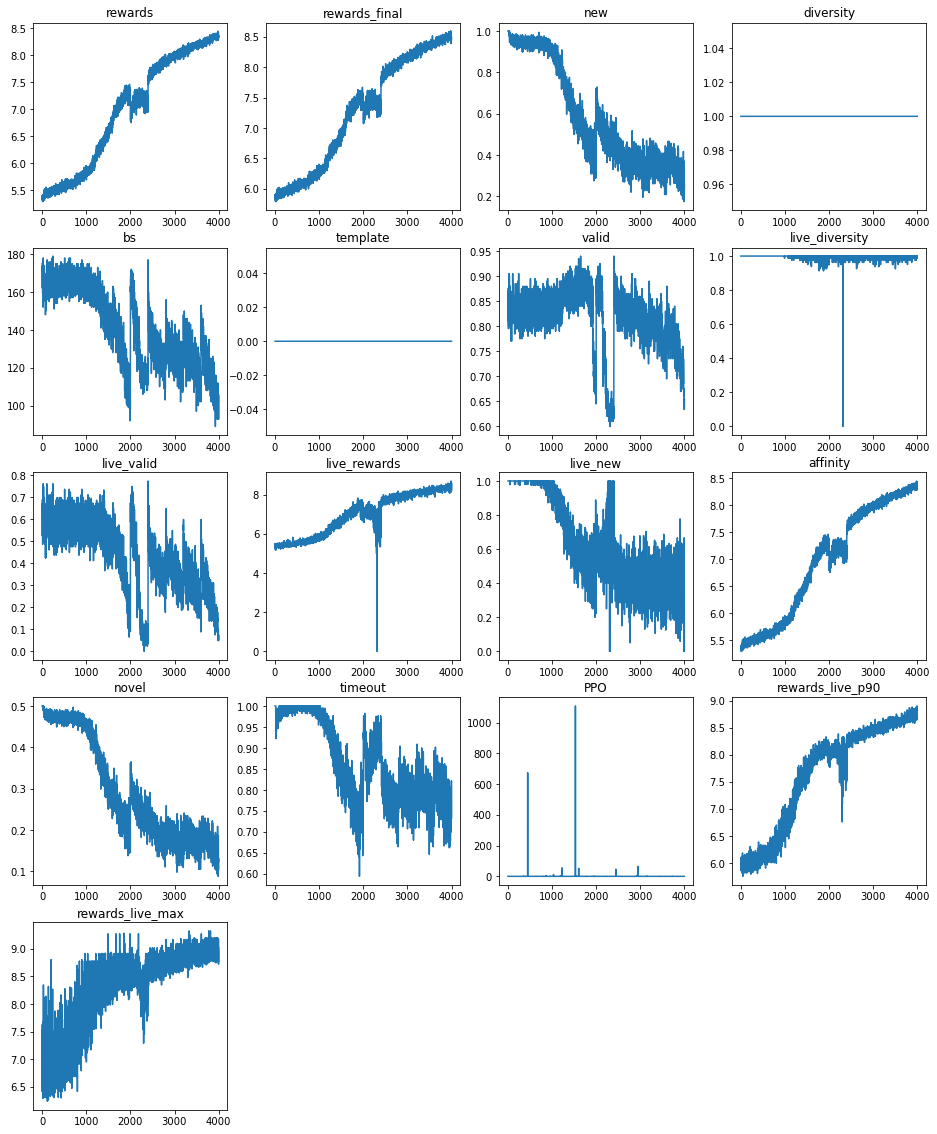

In [ ]:
env.log.plot_metrics()

## Evaluation

We determined before that a compound scoring 9.12 or higher would be in the top 1% of samples. Looking at the log, we see 32 samples with a score of more than 9.12. 68% of these samples are novel samples that came from the model run rather than the original dataset (added in by `sampler5`).

The generative run also found 5 samples with a score of 9.25 or higher, putting them in the top 0.7% of compounds relative to the original dataset

In [ ]:
env.log.df[env.log.df.affinity>=9.12].sources.value_counts()

data_buffer    10
base_buffer     8
live_buffer     7
live            7
Name: sources, dtype: int64

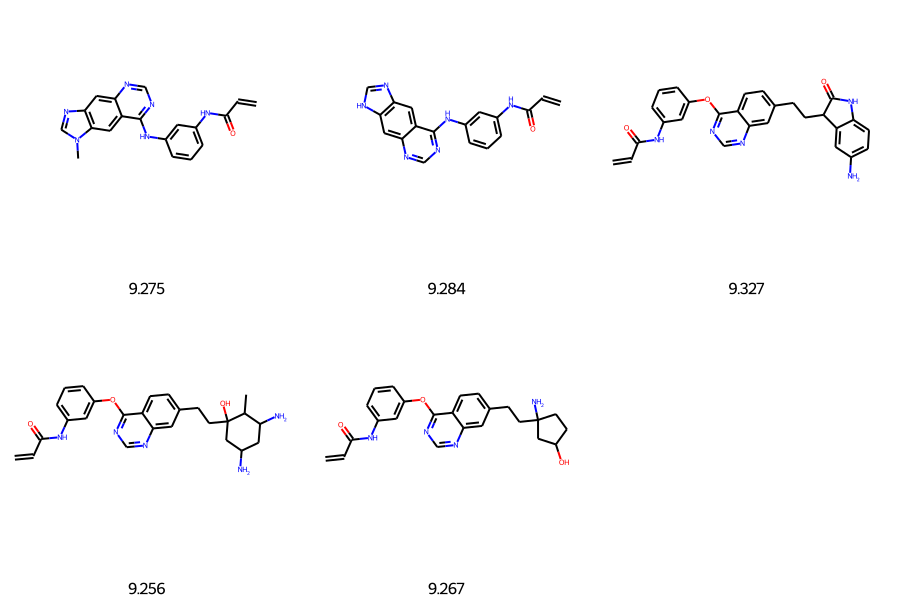

In [ ]:
subset = env.log.df[(env.log.df.affinity>=9.25) & ~(env.log.df.sources=='data_buffer')]
mols = to_mols(subset.samples.values)
legends = [f'{subset.rewards.values[i]:.3f}' for i in range(subset.shape[0])]
draw_mols(mols, legends=legends)

In the interest of time, we will stop here. That said, the model isn't done. If you invest a few more hours into training, you can find compounds that score 10 or higher, beating out all other compounds in the original dataset (relative to predicted score rather than actual score)

Optional: save log dataframe

In [ ]:
# env.log.df.to_csv('untracked_files/egfr_generative_screen.csv', index=False)